In [1]:
from src import Data, myModel
import matplotlib.pyplot as plt

C:\Users\yuch\Downloads\anaconda3\envs\nz_convnet\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np

#### load X-Y samples from block1, and split into train and test sets

In [20]:
data = Data('./data/block1/', start=0, num=500)
min_list, max_list = data.get_MinMax('./data/block1/raw_data/workspace/sent_geo.tif')
X_trn, Y_trn = data.load_XY(min_list, max_list, as_arr=True)
# X_trn, X_tst, Y_trn, Y_tst = data.trn_tst_split(test_rate=0.1, random_seed=42)

#### visualize images and labels

Text(0.5,1,'lithological mappinp')

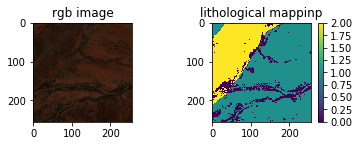

In [21]:
idx = 0
img = X_trn[idx,:,:,:]
lbl = Y_trn[idx,:,:,:]

img_rgb = img[:,:,:3][:,:,::-1]
plt.subplot(221)
plt.imshow(img_rgb)
plt.title('rgb image')
plt.subplot(222)
plt.imshow(np.argmax(lbl, axis=2))
plt.colorbar()
plt.title('lithological mappinp')

#### start to build and train Conv2D

In [22]:
conv = myModel()

# build Conv2D
conv.build_Conv2D(num_bands=X_trn.shape[-1], n_ch_list=[64,64], use_tfboard=True)

# now the tensorboard event file is saved in ./logs
# the training process, graph and statistics can be
# visualize by tensorboard

# compile with loss and optimizer
conv.compile_model(verbose=False)

# build callback for the details of train process
conv.build_callbackList()

building Conv2D ...
[64, 64]
[64]
compiling model ...


In [23]:
# load data from last checkpoint
conv.load_checkpoint()

In [ ]:
# start to training
conv.fit_model(X_trn=X_trn, Y_trn=Y_trn, epochs=20, verbose=1)

Train on 400 samples, validate on 100 samples
Epoch 1/20


In [ ]:
data = Data('./data/block1/', start=500, num=1000)
min_list, max_list = data.get_MinMax('./data/block1/raw_data/workspace/sent_geo.tif')
X_trn, Y_trn = data.load_XY(min_list, max_list, as_arr=True)

In [ ]:
conv.load_checkpoint()
conv.fit_model(X_trn=X_trn, Y_trn=Y_trn, epochs=40, verbose=1)

#### predict on test data

In [14]:
# conv.save_weights()
# conv.load_weights('./Conv2D/model-1.hdf5')

In [9]:
Y_preds = conv.predict(X_tst=X_tst)

50/50 [==============================] - 41s 823ms/step


#### visualize predicted Y

Text(0.5,1,'prediction')

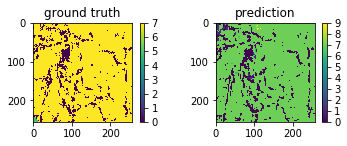

In [29]:
idx = 16
_pred = np.argmax(Y_preds[idx,:,:,:], axis=2)
_tst = np.argmax(Y_tst[idx,:,:,:], axis=2)
plt.subplot(221)
plt.imshow(_tst)
plt.colorbar()
plt.title('ground truth')
plt.subplot(222)
plt.imshow(_pred)
plt.colorbar()
plt.title('prediction')

#### calculate the accuracy

In [18]:
acc_list = []
for i in range(Y_tst.shape[0]):
    tmp_pred = np.argmax(Y_preds[i,:,:,:], axis=2)
    tmp_tst = np.argmax(Y_tst[i,:,:,:], axis=2)
    acc_list.append(np.where(tmp_pred == tmp_tst)[0].shape[0]/(256*256))
print('mean accuracy on test data is {0}, std is {1}'.format(np.mean(acc_list), np.std(acc_list)))
print('max is {0}, min is {1}'.format(max(acc_list), min(acc_list)))

mean accuracy on test data is 0.6146722412109376, std is 0.24136185770976767
max is 0.9630889892578125, min is 0.1969757080078125
